### Chapter 3 - Computer Vision

**This week's exercise has 4 tasks, for a total of 10 points. Don't forget to submit your solutions to GitHub!**

In this chapter, we want you to become proficient at the following tasks:
- Building a modern PyTorch segmentation model
- Training a modern model on a real-world segmentation task and achieving passable results

**Note**: This is the last exercise concerning pure computer vision. Starting next week, we will begin with Natural Language Processing, i.e. text data. Therefore, don't worry too much if this exercise feels hard or if you can't complete all of it ;)

#### Chapter 3.5 - Segmentation

In previous tasks, we solved classification problems - we provide some input(s), typically an image, and get out a few numbers, which are the predicted pseudo-probabilities that our input belongs to some class, such as "tumor" or "no tumor". For this exercise, we will explore a new task that is extremely common in medical AI research and in clinical practice. This task is called segmentation. In segmentation, the goal is to go from an input image to one or several segmentations (also called *segmentation maps*) of that image. For the example of LiTS, this means that our input remains the same - a 256x256 image with 1 channel. However, our model outputs and targets are now different - they also have the shape 256x256 pixels, times the number of output classes, in our case 3 (background, liver, liver+tumor). Each 256x256 output is basically a map of which pixels in the original image belong to a certain class with what (pseudo-)probability. The training objective, in its simplest form, is also the same; Cross-Entropy Loss, but per pixel, instead of per-image.

To solve today's tasks, we will need to build ourselves a few new things that look almost the same as things we have already built.

**Task 1 (2 points)**: We will need a new Dataset class. It is the same as usual, except this time, when we return image and target in the getitem method, our target is now also a multi-dimensional tensor of size.

We will return two kinds of targets - class-index targets and one-hot encoded targets. Class-index targets you already know. Every pixel is assigned a class, which can be 0 for background, 1 for liver, and 2 for lesions. The corresponding tensor has the size $H * W$. One-hot encoded targets instead have size $C * H * W$ - each channel is one class (the 0th channel is background, etc.), and the values for each pixel in a channel are 1 if that pixel belongs to that class and 0 if not. We will need both later on - class-index targets because that is the input for the normal CrossEntropyLoss, and one-hot targets because we will use them in this format for our DiceLoss.

Since the "background" class has no segmentations, you will have to improvise them from the existing segmentations for this task.

Your dataset class should return both targets at the end of the \_\_getitem\_\_ method like this: `return image, c_targets, oh_targets`.

In [5]:
!gdown 1TItTaso19GFTPdDnynVnqJvHsCm_RGlI
!rm -rf ./sample_data/
!unzip -qq Clean_LiTS.zip
!rm ./Clean_LiTS.zip


Downloading...
From (original): https://drive.google.com/uc?id=1TItTaso19GFTPdDnynVnqJvHsCm_RGlI
From (redirected): https://drive.google.com/uc?id=1TItTaso19GFTPdDnynVnqJvHsCm_RGlI&confirm=t&uuid=df427c91-495e-4c76-aa63-caf034ebcf03
To: /content/Clean_LiTS.zip
100% 2.56G/2.56G [00:31<00:00, 81.0MB/s]
             filename                  liver_segmentation  liver_visible  \
0    volume-101_0.png    segmentation-101_livermask_0.png          False   
1    volume-101_1.png    segmentation-101_livermask_1.png          False   
2   volume-101_10.png   segmentation-101_livermask_10.png          False   
3  volume-101_100.png  segmentation-101_livermask_100.png          False   
4  volume-101_101.png  segmentation-101_livermask_101.png          False   

                   lesion_segmentation  lesion_visible  
0    segmentation-101_lesionmask_0.png           False  
1    segmentation-101_lesionmask_1.png           False  
2   segmentation-101_lesionmask_10.png           False  
3  segmentati

In [18]:
import torch
import torchvision.transforms.functional as ttf

class LiTS_Segmentation_Dataset(torch.utils.data.Dataset):

    def __init__(self, csv: str, mode: str):

        self.csv = csv
        self.data = pd.read_csv(self.csv)
        self.mode = mode
        assert mode in ["train", "val", "test"]

    def __len__(self):

        return len(self.data)


    def __getitem__(self, idx: int):

        file = self.data.loc[idx, "filename"]
        with PIL.Image.open(f"./Clean_LiTS/{self.mode}/{file}") as f:
            f = f.convert("L")
            image = ttf.pil_to_tensor(f)
        file = self.data.loc[idx, "liver_segmentation"]
        with PIL.Image.open(f"./Clean_LiTS/{self.mode}/{file}") as f:
            f = f.convert("L")
            liver = ttf.pil_to_tensor(f)
        file = self.data.loc[idx, "lesion_segmentation"]
        with PIL.Image.open(f"./Clean_LiTS/{self.mode}/{file}") as f:
            f = f.convert("L")
            lesion = ttf.pil_to_tensor(f)

        image = image.to(dtype = torch.float32)
        image -= torch.min(image)
        image /= torch.max(image)

        c_targets = torch.zeros_like(image, dtype=torch.long)
        c_targets[liver > 0] = 1
        c_targets[lesion > 0] = 2

        oh_targets = torch.zeros(3, image.shape[1], image.shape[2], dtype=torch.float32)
        oh_targets[0] = (c_targets == 0).float()
        oh_targets[1] = (c_targets == 1).float()
        oh_targets[2] = (c_targets == 2).float()

        return image, c_targets, oh_targets

        # We need both the class-index version for the cross-entropy loss and the one-hot version for our dice loss later
        # return image, c_targets, oh_targets

In [22]:
import torch
import torchvision.transforms.functional as ttf
import pandas as pd
import PIL.Image
import os
import matplotlib.pyplot as plt

# CSV laden
df = pd.read_csv("./Clean_LiTS/train_classes.csv")

# Zeilen filtern, wo eine Läsion sichtbar ist
lesion_rows = df[df["lesion_visible"] == True]

# Ausgabe der ersten paar Zeilen
print("Erste Zeilen mit Lesion sichtbar:")
print(lesion_rows.head())

# Optional: den Index des ersten Samples mit Lesion
if not lesion_rows.empty:
    first_index = lesion_rows.index[0]
    print(f"\nErster Index mit sichtbarer Läsion: {first_index}")
else:
    print("Keine sichtbare Läsion im Dataset gefunden!")

# 1️⃣ Dataset-Instanz erstellen
dataset = LiTS_Segmentation_Dataset(csv="./Clean_LiTS/train_classes.csv", mode="train")

# 2️⃣ Prüfen, wie viele Samples es gibt
print(f"Anzahl der Samples: {len(dataset)}")

# 3️⃣ Ein Beispiel laden (z. B. erstes Sample)
image, c_targets, oh_targets, liver = dataset[340]


print(oh_targets)


# 4️⃣ c_target untersuchen
mask_np = c_targets.squeeze().numpy()  # (H, W) Array

total_pixels = mask_np.size
non_zero_pixels = (mask_np == 0).sum()
liver_pixels = (mask_np == 1).sum()
lesion_pixels = (mask_np == 2).sum()

print(f"Total pixels: {total_pixels}")
print(f"Non-zero pixels (Leber + Läsion): {non_zero_pixels}")
print(f"Liver pixels (class 1): {liver_pixels}")
print(f"Lesion pixels (class 2): {lesion_pixels}")

Erste Zeilen mit Lesion sichtbar:
               filename                  liver_segmentation  liver_visible  \
340  volume-101_404.png  segmentation-101_livermask_404.png           True   
341  volume-101_405.png  segmentation-101_livermask_405.png           True   
342  volume-101_406.png  segmentation-101_livermask_406.png           True   
343  volume-101_407.png  segmentation-101_livermask_407.png           True   
344  volume-101_408.png  segmentation-101_livermask_408.png           True   

                     lesion_segmentation  lesion_visible  
340  segmentation-101_lesionmask_404.png            True  
341  segmentation-101_lesionmask_405.png            True  
342  segmentation-101_lesionmask_406.png            True  
343  segmentation-101_lesionmask_407.png            True  
344  segmentation-101_lesionmask_408.png            True  

Erster Index mit sichtbarer Läsion: 340
Anzahl der Samples: 35484
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1.,

In [ ]:
from torch.utils.data import Dataset, DataLoader

train_dataset = LiTS_Segmentation_Dataset(csv="./Clean_LiTS/train_classes.csv", mode="train")
val_dataset = LiTS_Segmentation_Dataset(csv="./Clean_LiTS/val_classes.csv", mode="val")
test_dataset = LiTS_Segmentation_Dataset(csv="./Clean_LiTS/test_classes.csv", mode="test")

batch_size = 32

train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    num_workers = 4,
    prefetch_factor = 2,
    shuffle = True,
    drop_last = True
)

val_dataloader = DataLoader(
    dataset = val_dataset,
    batch_size = batch_size,
    num_workers = 4,
    shuffle = True,
    drop_last = True
)

test_dataloader = DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    num_workers = 4,
    shuffle = True,
    drop_last = True
)

**Task 2 (2 points)**: Plot a few images that contain livers and tumors, as well as their corresponding segmentation maps. Do they look correct? Is there anything special to note?

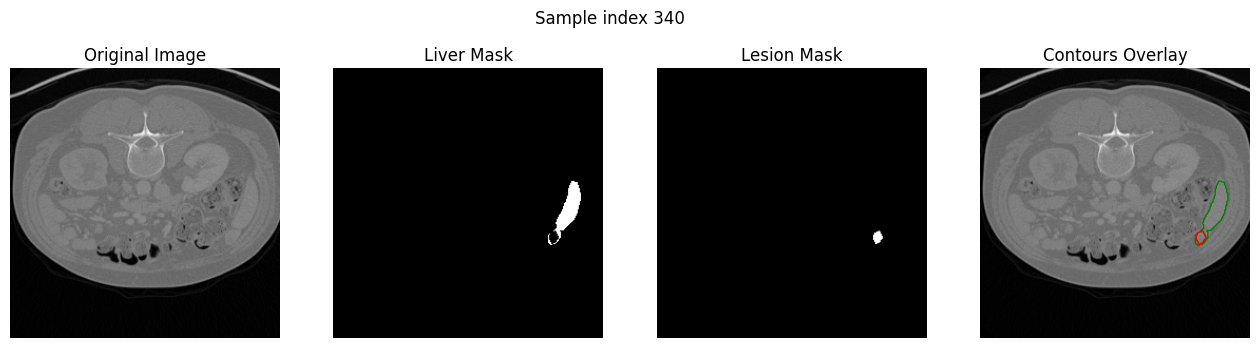

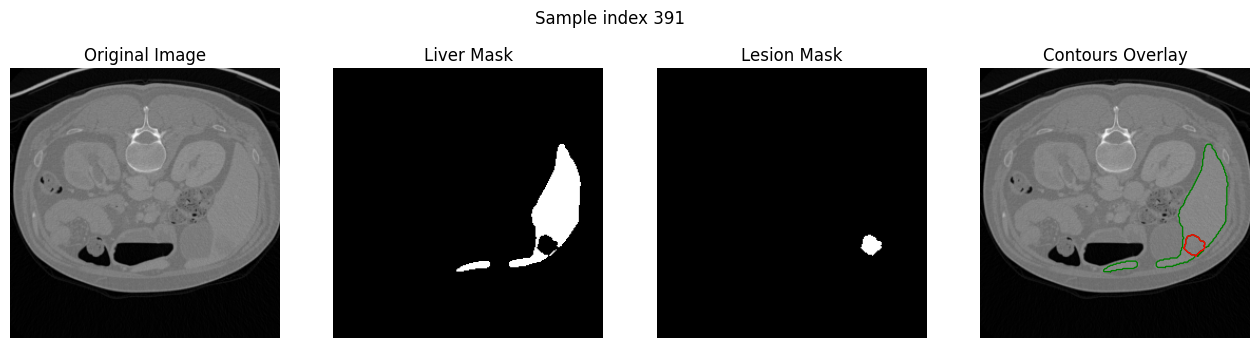

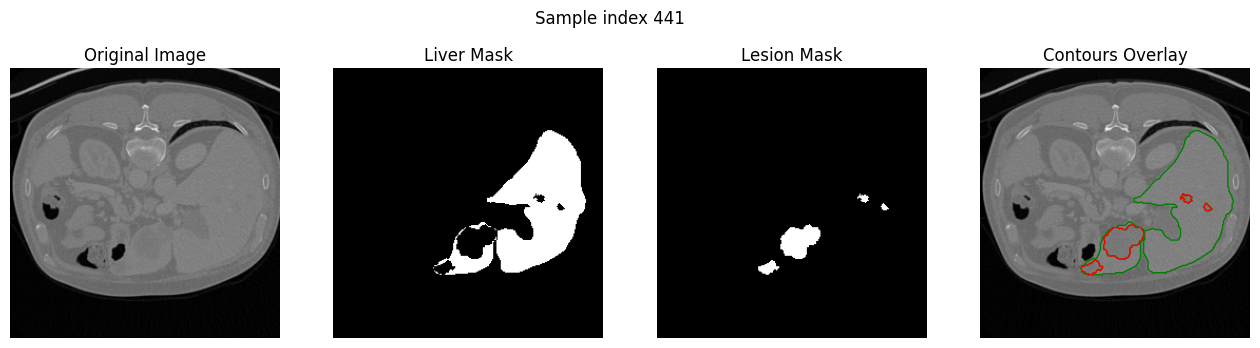

In [27]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from skimage import measure

def plot_segmentation_contours(image, c_target, title="Sample"):
    img_np = image.squeeze().numpy()
    mask_np = c_target.squeeze().numpy()

    liver_mask = (mask_np == 1)
    lesion_mask = (mask_np == 2)

    plt.figure(figsize=(16, 4))

    # 1️⃣ Original Image
    plt.subplot(1, 4, 1)
    plt.title("Original Image")
    plt.imshow(img_np, cmap="gray")
    plt.axis("off")

    # 2️⃣ Leber Maske
    plt.subplot(1, 4, 2)
    plt.title("Liver Mask")
    plt.imshow(liver_mask, cmap="gray")
    plt.axis("off")

    # 3️⃣ Läsions Maske
    plt.subplot(1, 4, 3)
    plt.title("Lesion Mask")
    plt.imshow(lesion_mask, cmap="gray")
    plt.axis("off")

    # 4️⃣ Originalbild mit Konturen
    plt.subplot(1, 4, 4)
    plt.title("Contours Overlay")
    plt.imshow(img_np, cmap="gray")
    plt.axis("off")

    # Konturen für Leber grün
    contours_liver = measure.find_contours(liver_mask, 0.5)
    for contour in contours_liver:
        plt.plot(contour[:, 1], contour[:, 0], color='green', linewidth=1)

    # Konturen für Läsion rot
    contours_lesion = measure.find_contours(lesion_mask, 0.5)
    for contour in contours_lesion:
        plt.plot(contour[:, 1], contour[:, 0], color='red', linewidth=1)

    plt.suptitle(title)
    plt.show()


# --------------------------
# Plotten von ein paar Samples mit Leber + Läsion
# --------------------------
count = 0
max_samples = 3
skip_slices = 50  # Anzahl Slices, die wir nach einem gefundenen Sample überspringen

idx = 0
while idx < len(dataset) and count < max_samples:
    image, c_target, oh_target, liver = dataset[idx]

    mask_np = c_target.squeeze().numpy()
    if (mask_np == 1).any() and (mask_np == 2).any():
        plot_segmentation_contours(image, c_target, title=f"Sample index {idx}")
        count += 1
        idx += skip_slices  # nach dem Plot überspringen
    else:
        idx += 1  # sonst einfach zum nächsten Sample

**Task 3 (2 points)**: Next, we need a different loss function. At the bottom, we provide a training/testing loop that already contains cross-entropy loss and a functional segmentation model, plus evaluation. We have learned in the lecture that DICE score, and by extension a DICE-based loss, can be useful for imbalanced classes. We have also discovered that LiTS 2017 contains a class imbalance - slices with tumors are much more rare than slices with livers. Hence, we will make our own DICE loss.

The formula for the DICE loss is computed as follows: $1 - \frac{2 * (|X \land Y|)+\epsilon}{|X|+|Y|+\epsilon}$, where $X$ is the prediction and $Y$ the target.

The DICE Loss class you create should fulfill the following criteria:
- It subclasses torch.nn.module.
- It is a class that implements an \_\_init\_\_ function.
- The loss also implements a \_\_forward\_\_ function that accepts as inputs a prediction tensor and a target tensor, both of shape B x 3 x 256 x 256 - 3 channels because we will segment background, liver, and liver+tumor again. The output is the computed loss.
- You may add class weighting to offset the class imbalance.

Your total loss should be `total_loss = ce_loss + dice_loss`, and your backward pass should be `total_loss.backward()`.
Run the training for a few epochs, once with and once without DICE loss included as part of the overall loss. In your experiment, which version worked better?

In [ ]:
import torch, torch.nn as nn, torch.nn.functional as nnf

def compute_dice_score(prediction: torch.Tensor, target: torch.Tensor):

    """
    Computes the dice score for one class.
    """

    prediction = prediction.to(dtype = torch.bool)
    target = target.to(dtype = torch.bool)

    intersection = torch.sum(prediction * target)   # TP
    p_cardinality = torch.sum(prediction)           # TP+FP
    t_cardinality = torch.sum(target)               # TP+FN
    cardinality = p_cardinality + t_cardinality
    eps = 1e-8

    if cardinality != 0:
        dice = (2 * intersection + eps) / (cardinality + eps) # 2*TP / (2*TP+FP+FN + eps)
    else:
        dice = None

    return dice

class BinaryDiceLoss(nn.Module):

    """
    Binary Dice Loss. Targets must be one-hot encoded.
    Needed to make a full DICE loss, this computes dice loss for one channel.
    """

    def __init__(self):

        pass

    def forward(self, prediction: torch.Tensor, target: torch.Tensor):

        pass

class DiceLoss(nn.Module):

    """
    Dice Loss. Targets must be one-hot encoded.
    """

    def __init__(self, num_classes: int):

        pass

    def forward(self, predictions: torch.Tensor, targets: torch.Tensor):

        pass


**Task 4 (4 points)**: Finally, we want to make our own model that can handle segmentations. For this course, we will build ourselves a U-Net. The original paper can be found here: https://arxiv.org/pdf/1505.04597.

The input dimensions for the network will be the usual B x 1 x 256 x 256. The output dimensions should be B x 3 x 256 x 256. We have three output channels because we will still predict classes 0 (background), 1 (liver) and 2 (liver tumor) - this time, however, we predict the classes on a per-pixel basis.

Since our input images have vastly smaller dimensions compared to those used in the original UNet-Paper, we will opt for a different scale of UNet. The general design remains the same as in the paper, except:

- We will only downsample 3 times by a factor of 2, using MaxPool (for a minimum resolution 32x32).
- Our 3x3 Convolutions will have Padding. Consequently, there will be no cropping during skip connections
- We will only have 3 skip connections.
- We will go for fewer maximum channels (as we have only 3 downsampling steps, we will have 64, 128, 256, and 512 channels).
- Our final output will be 3 channels wide, not 2 (we predict background, liver, and liver tumors).

Note that training a segmentation models takes a little while - we do not award points for results here, because it would mean that you would have to wait a long time to see whether your changes helped performance. All we want to see is that your model learns anything useful at all. As a rough guideline, you will probably start seeing ok liver segmentations after 1 epoch, and good liver and ok lesion segmentations after 2 or 3 epochs.

If everything works correctly, you can copy the previous training loop and should get some good results. Don't forget to look at some of your predictions! Are they reasonable? Empty? Weird? Can you discover some kind of systemic issues with your predictions?

In [ ]:
class UNet(nn.Module):

    def __init__(self):

        pass

    def __forward__(self):

        pass

In [ ]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

model = UNet() # Your model class goes here
model = model.to(device)

dice_loss = DiceLoss(num_classes = 3) # Your dice loss class goes here
ce_loss = nn.CrossEntropyLoss(
    weight = torch.tensor([1.0, 5.0, 20.0]).to(device = device),
    reduction = "mean",
    #ignore_index = 0
    )

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [ ]:
# If your model and loss work, this should at least execute successfully.
# If you only wish to test your model, just comment out the dice_loss component everywhere.

from tqdm.auto import tqdm

num_epochs = 5
avg_liver_dice = 0
avg_lesion_dice = 0
dice_weight = 1
ce_weight = 1

for epoch in range(num_epochs):

    for step, (data, c_targets, oh_targets) in enumerate(train_dataloader):

        optimizer.zero_grad()
        data, c_targets, oh_targets = data.to(device), c_targets.to(device), oh_targets.to(device)
        predictions = model(data)

        loss_1 = dice_loss(predictions, oh_targets)
        loss_2 = ce_loss(predictions, c_targets)
        total_loss = loss_1 * dice_weight + loss_2 * ce_weight # We could weight contributions from the different loss components here, although 1-to-1 should do just fine

        if step % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}]\t Step [{step+1}/{len(train_dataloader.dataset)//batch_size}]\t Loss: {total_loss.item():.4f}")

        total_loss.backward()
        optimizer.step()

        # Validate once after every epoch
        model.eval()

        # Don't track gradients for validation
        with torch.no_grad():

            losses = []
            background_dices = []
            background_counts = []
            liver_dices = []
            liver_counts = []
            lesion_dices = []
            lesion_counts = []
            batch_sizes = []

            for val_step, (data, c_targets, oh_targets) in enumerate(tqdm(val_dataloader)):

                data, c_targets, oh_targets = data.to(device), c_targets.to(device), oh_targets.to(device)
                predictions = model(data)
                # Choose the likeliest prediction via argmax, then convert to one-hot, and put the new axis in front again
                p_arg = nnf.one_hot(torch.argmax(predictions, dim = 1), num_classes = 3).moveaxis(-1, 1)

                # loss
                loss_1 = dice_loss(predictions, oh_targets)
                loss_2 = ce_loss(predictions, c_targets)
                total_loss = loss_1 * dice_weight + loss_2 * ce_weight # We could weight contributions from the different loss components here, although 1-to-1 should do just fine

                losses.append(total_loss.item())
                batch_sizes.append(data.size()[0])

                background_seg = oh_targets[:, 0, :, :]
                liver_seg = oh_targets[:, 1, :, :]
                lesion_seg = oh_targets[:, 2, :, :]

                background_dice = compute_dice_score(p_arg[:,0,:,:], background_seg)
                background_counts.append(data.size()[0])
                background_dices.append(background_dice)

                if liver_seg.sum() != 0.0:
                    liver_dice = compute_dice_score(p_arg[:,1,:,:], liver_seg)
                    liver_counts.append(data.size()[0])
                    liver_dices.append(liver_dice)

                if lesion_seg.sum() != 0.0:
                    lesion_dice = compute_dice_score(p_arg[:,2,:,:], lesion_seg)
                    lesion_counts.append(data.size()[0])
                    lesion_dices.append(lesion_dice)

            avg_background_dice = sum([dice * size for dice, size in zip(background_dices, background_counts)])/sum(background_counts)
            avg_liver_dice = sum([dice * size for dice, size in zip(liver_dices, liver_counts)])/sum(liver_counts)
            avg_lesion_dice = sum([dice * size for dice, size in zip(lesion_dices, lesion_counts)])/sum(lesion_counts)

            avg_loss = sum([l * bs for l, bs in zip(losses, background_counts)]) / sum(background_counts)
            print(f"Epoch: {epoch+1},\t Validation Loss: {avg_loss:.4f},\t Liver Dice Score: {avg_liver_dice:.4f}, \t Lesion Dice Score: {avg_lesion_dice:.4f}")

            # After we are done validating, let's not forget to go back to storing gradients.
            model.train()

In [ ]:
# Test once
model.eval()

# Don't track gradients for testing
with torch.no_grad():

    losses = []
    background_dices = []
    background_counts = []
    liver_dices = []
    liver_counts = []
    lesion_dices = []
    lesion_counts = []
    batch_sizes = []

    for test_step, (data, c_targets, oh_targets) in enumerate(tqdm(test_dataloader)):

        data, c_targets, oh_targets = data.to(device), c_targets.to(device), oh_targets.to(device)
        predictions = model(data)
        # Choose the likeliest prediction via argmax, then convert to one-hot, and put the new axis in front again
        p_arg = nnf.one_hot(torch.argmax(predictions, dim = 1), num_classes = 3).moveaxis(-1, 1)

        # loss
        loss_1 = dice_loss(predictions, oh_targets)
        loss_2 = ce_loss(predictions, c_targets)
        total_loss = loss_1 * dice_weight + loss_2 * ce_weight # We could weight contributions from the different loss components here, although 1-to-1 should do just fine

        losses.append(total_loss.item())
        batch_sizes.append(data.size()[0])

        background_seg = oh_targets[:, 0, :, :]
        liver_seg = oh_targets[:, 1, :, :]
        lesion_seg = oh_targets[:, 2, :, :]

        background_dice = compute_dice_score(p_arg[:,0,:,:], background_seg)
        background_counts.append(data.size()[0])
        background_dices.append(background_dice)

        if liver_seg.sum() != 0.0:
            liver_dice = compute_dice_score(p_arg[:,1,:,:], liver_seg)
            liver_counts.append(data.size()[0])
            liver_dices.append(liver_dice)

        if lesion_seg.sum() != 0.0:
            lesion_dice = compute_dice_score(p_arg[:,2,:,:], lesion_seg)
            lesion_counts.append(data.size()[0])
            lesion_dices.append(lesion_dice)

    avg_background_dice = sum([dice * size for dice, size in zip(background_dices, background_counts)])/sum(background_counts)
    avg_liver_dice = sum([dice * size for dice, size in zip(liver_dices, liver_counts)])/sum(liver_counts)
    avg_lesion_dice = sum([dice * size for dice, size in zip(lesion_dices, lesion_counts)])/sum(lesion_counts)

    avg_loss = sum([l * bs for l, bs in zip(losses, background_counts)]) / sum(background_counts)
    print(f"Epoch: {epoch+1},\t Test Loss: {avg_loss:.4f},\t Liver Dice Score: {avg_liver_dice:.4f}, \t Lesion Dice Score: {avg_lesion_dice:.4f}")

In [ ]:
# Try looking at some images and predicted segmentations to see how badly or how well you've done

